### Athens University of Economics and Business
### Department of Management Science & Technology
### Msc in Business Analytics

### Course : Machine Learning & Content Analytics
* # Instructors : H.Papageorgiou, G.Perakis
* # Students : Xheni Cobanaj (f2822117), Nikolaos Mantzakos (f2822107), Dimitris Papageorgiou (f2822109)

# Transformers Transfer Learning - Fine Tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline
# import re
# import itertools
# import string
# import collections
# from collections import Counter
# from sklearn.preprocessing import LabelEncoder
# import nltk
# from nltk.corpus import stopwords
# from nltk import word_tokenize
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/MyDrive/mbti_1.csv"

/bin/bash: ls /content/drive/MyDrive/mbti_1.csv: No such file or directory


In [4]:
df=pd.read_csv("/content/drive/MyDrive/mbti_1.csv",header=0)
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
# function for producing the four binary target variables
def categories(df):
  df['Extraversion'] = ''
  df['Sensing'] = ''
  df['Thinking'] = ''
  df['Judging'] = ''

  for i in df.index:    
    if "E" in df['type'][i]:
      df['Extraversion'][i] = 1
    else:
      df['Extraversion'][i] = 0

    if "S" in df['type'][i]:
      df['Sensing'][i] = 1
    else:
      df['Sensing'][i] = 0
    
    if "T" in df['type'][i]:
      df['Thinking'][i] = 1
    else:
      df['Thinking'][i] = 0
    
    if "J" in df['type'][i]:
      df['Judging'][i] = 1
    else:
      df['Judging'][i] = 0
  return(df)

In [6]:
data = df.copy()

* Loading transformers and other necessary libraries.

In [7]:
#!pip install sentence-transformers
!pip install -q transformers

     |████████████████████████████████| 4.7 MB 26.4 MB/s 
     |████████████████████████████████| 120 kB 67.9 MB/s 
     |████████████████████████████████| 6.6 MB 50.5 MB/s 


In [8]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification,TrainingArguments,Trainer
from transformers import DataCollatorWithPadding
from transformers import pipeline

* Defining the distilbert tokenizer.

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

## Dataset Preprocess

In [10]:
categories(data)
#data['labels'] = data.iloc[:, 1:].values.tolist()
data.head()

,type,posts,Extraversion,Sensing,Thinking,Judging
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,1


In [11]:
#data.to_csv('tokenized_data.csv', sep=',')

In [12]:
X = list(data['posts'])
y = list(zip(data['Extraversion'],data['Sensing'],data['Thinking'],data['Judging']))

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.1,
                                                            random_state=20,
                                                            stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10, 
                                                  random_state=20,
                                                  stratify=y_train_val)

In [14]:
for i in range(0,4,1):
  k = [item[i] for item in y_train]
  prop = round(sum(k)/len(k),2)
  print('Label',i,'Proportions:' ,prop, 1- prop)

Label 0 Proportions: 0.23 0.77
Label 1 Proportions: 0.14 0.86
Label 2 Proportions: 0.46 0.54
Label 3 Proportions: 0.4 0.6


* Tokenizing the datasets with distilberts tokenizers with max sequence length of 512.

In [15]:
X_train_tokenized = tokenizer(X_train, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val,truncation=True, max_length=512)

In [16]:
#def text_preprocess(df):
    #return tokenizer(df, truncation=True,return_tensors='pt')
#data['tokenized_posts'] = data['posts'].apply(text_preprocess)
#data.tokenized_posts[0]

* Defining the datasets in torch datasets class for feeding them in the models.

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx],dtype=torch.float)
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


In [18]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

* Defining datacollator with padding for dynamic padding at every batch during training.

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

* Defining a distilebert model for multilabel sequence classification.
* With problem type we change the loss function to binary cross entropy.

In [20]:
num_labels = len(y_train[0])

model = DistilBertForSequenceClassification.from_pretrained( "distilbert-base-uncased", num_labels=num_labels, problem_type = "multi_label_classification")


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [21]:
#labels = torch.nn.functional.one_hot(torch.tensor([train_dataset.labels]), num_classes=num_labels).to(torch.float)
#labels
#loss = model(train_dataset).loss
#loss.backward()
#loss

In [22]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

## Training

* Setting the training arguments for training in order to fine tune the distilbert's head in our dataset.

In [23]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [24]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7026
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1760


Step,Training Loss,Validation Loss
500,0.505000,0.424404
1000,0.386600,0.396582
1500,0.331900,0.391554


***** Running Evaluation *****
  Num examples = 781
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 781
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 781
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Mod

TrainOutput(global_step=1760, training_loss=0.3931397047909823, metrics={'train_runtime': 1408.8103, 'train_samples_per_second': 19.949, 'train_steps_per_second': 1.249, 'total_flos': 3722996555808768.0, 'train_loss': 0.3931397047909823, 'epoch': 4.0})

In [25]:
trainer.save_model()

Saving model checkpoint to ./results
Configuration saved in ./results/config.json
Model weights saved in ./results/pytorch_model.bin
tokenizer config file saved in ./results/tokenizer_config.json
Special tokens file saved in ./results/special_tokens_map.json


## Model Evaluation

* Computing some metrics on validation data set to get information of models peformance.

In [26]:
from sklearn.metrics import accuracy_score,hamming_loss,multilabel_confusion_matrix,classification_report

In [27]:
def exact_match_ratio(y_true,y_pred):
  score = accuracy_score(y_true,y_pred)
  return print("exact_match_ratio:", score)

In [28]:
def hamming_score(y_true,y_pred):
  score = 1 - hamming_loss(y_true,y_pred)
  return print("Hamming score:", score)

In [29]:
eval_dataset = Dataset(X_val_tokenized)

In [30]:
final_model = DistilBertForSequenceClassification.from_pretrained("/content/results/checkpoint-1500", num_labels=num_labels, problem_type = "multi_label_classification")
eval_trainer = Trainer(final_model ,data_collator=data_collator)

loading configuration file /content/results/checkpoint-1500/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "multi_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.21.2",
  "vocab_size": 30522
}

loading weights file /content/results/checkpoint-1500/pytorch_model.bin
All model checkpoin

# Save best weights

In [31]:
# Specify a path
PATH = "distil_bert_model_weights.pt"

# Save
torch.save(final_model.state_dict(), PATH)

In [32]:
raw_pred, _, _  = eval_trainer.predict(eval_dataset)

raw_pred

***** Running Prediction *****
  Num examples = 781
  Batch size = 8


array([[ 1.1125752, -1.814836 ,  1.7033994, -1.6265266],
       [-3.1290498, -3.3388631, -2.6261578, -2.9892976],
       [-1.9683264, -2.187715 , -3.10459  , -2.1130505],
       ...,
       [-0.2154934, -2.9273424,  3.4007416, -1.1927748],
       [-2.2618341,  2.0850298,  1.7484396, -1.5599343],
       [-2.697711 , -2.641173 ,  2.2633696, -0.6126831]], dtype=float32)

In [33]:
# Preprocess raw predictions
y_pred = np.where(raw_pred > 0, 1, 0)
y_pred

array([[1, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 1, 1, 0],
       [0, 0, 1, 0]])

In [34]:
y_true = np.array(y_val)
y_true

array([[0, 0, 1, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 0]])

In [35]:
print(exact_match_ratio(y_true,y_pred))
print(hamming_score(y_true,y_pred))

exact_match_ratio: 0.5749039692701664
None
Hamming score: 0.8412291933418694
None


In [36]:
y_true[:,0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,

* Another way to make predictions.

## Model Assessment at Test Set

* Observing the expected peformance of our model to production from test set.

In [37]:
X_test_tokenized = tokenizer(X_test,truncation=True, max_length=512)
test_dataset = Dataset(X_test_tokenized)

* Taking raw predictions(logits) from our model.

In [38]:
raw_pred, _, _  = eval_trainer.predict(test_dataset)

raw_pred

***** Running Prediction *****
  Num examples = 868
  Batch size = 8


array([[-2.777424  , -2.5549462 ,  2.822696  , -2.6845558 ],
       [-2.5243146 , -3.2279356 ,  1.0205779 , -2.4541361 ],
       [-2.5951223 , -2.543043  , -3.5788982 , -1.1973847 ],
       ...,
       [-2.5406735 , -2.4290488 ,  3.3051913 , -1.8712474 ],
       [-0.4427077 , -1.7675508 ,  3.329809  ,  0.4071705 ],
       [ 2.3974416 , -2.9057221 ,  0.12806389, -2.5171652 ]],
      dtype=float32)

* Convering logits to class predictions.
* logit > 0 equals to probabillity > 0.5  hence  logit > 0 --> class 1.

In [39]:
# Preprocess raw predictions
y_pred = np.where(raw_pred > 0, 1, 0)
y_pred

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [1, 0, 1, 0]])

In [40]:
y_true = np.array(y_test)
y_true

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       ...,
       [0, 1, 1, 1],
       [1, 0, 1, 0],
       [1, 0, 0, 0]])

* Exact Match Coefficient and hamming score.

In [41]:
print(exact_match_ratio(y_true,y_pred))
print(hamming_score(y_true,y_pred))

exact_match_ratio: 0.6002304147465438
None
Hamming score: 0.8453341013824884
None


In [42]:
from sklearn.metrics import confusion_matrix


In [43]:
labels = ["E/I", "S/N", "T/F","J/P"]

conf_mat_dict={}

for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

Confusion matrix for label E/I:
[[635  32]
 [ 82 119]]
Confusion matrix for label S/N:
[[728  20]
 [ 57  63]]
Confusion matrix for label T/F:
[[365 105]
 [ 62 336]]
Confusion matrix for label J/P:
[[479  46]
 [133 210]]


* Confusion Matrices for each target feature.

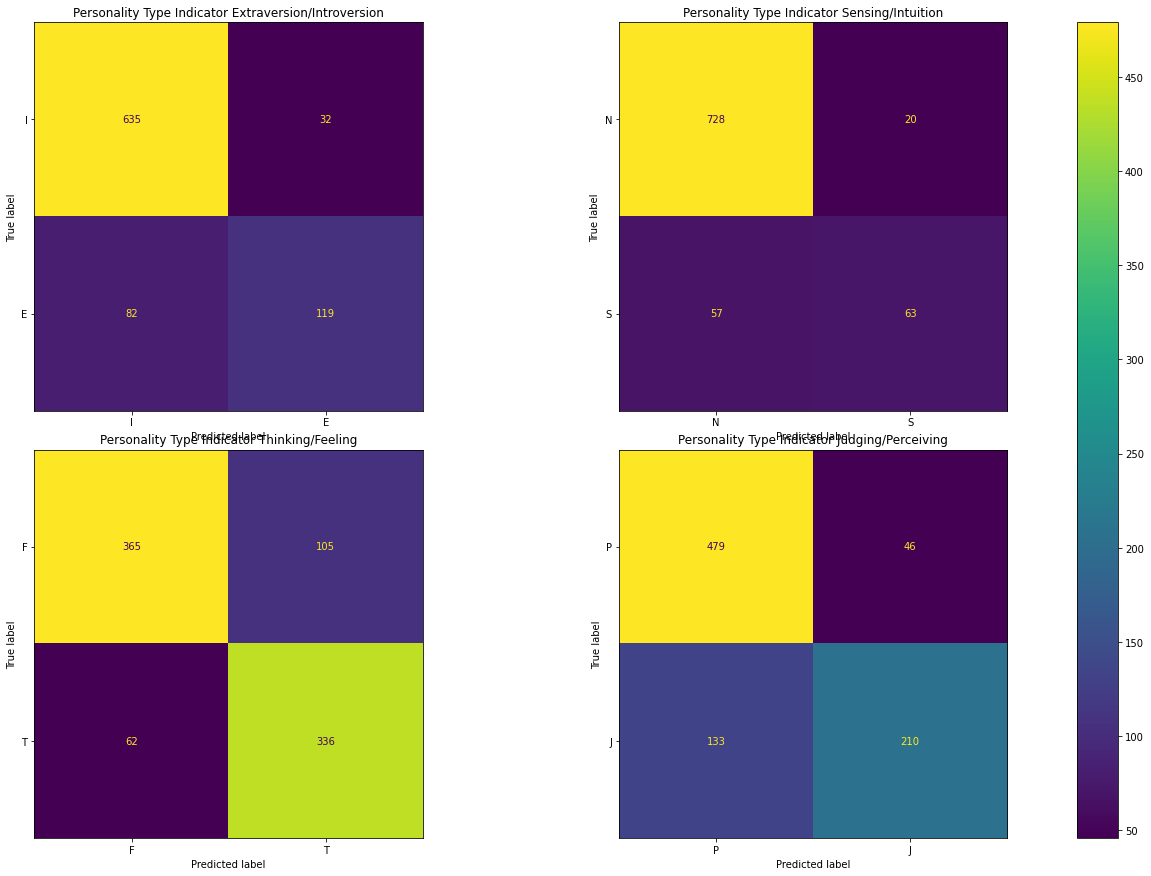

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels=(['I','E'],['N','S'],['F','T'],['P','J'])
types=['Extraversion/Introversion','Sensing/Intuition','Thinking/Feeling','Judging/Perceiving']

f, axes = plt.subplots(2, 2, figsize=(25, 15))
axes = axes.ravel()


for i in range(4):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i],
                                                   y_pred[:, i]),
                                  display_labels=labels[i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'Personality Type Indicator {types[i]}')
    # if i<10:
    #     disp.ax_.set_xlabel('')
    # if i%5!=0:
    #     disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
# plt.imshow(disp, interpolation='nearest', cmap=cmap)
f.colorbar(disp.im_, ax=axes)
plt.show()


* Accuracy for each personallity component.

In [45]:
I_E_acc = round(accuracy_score(y_true[:,0],y_pred[:,0]),2)
S_I_acc = round(accuracy_score(y_true[:,1],y_pred[:,1]),2)
T_F_acc = round(accuracy_score(y_true[:,2],y_pred[:,2]),2)
J_P_acc = round(accuracy_score(y_true[:,3],y_pred[:,3]),2)

print('Introversion / Extraversion Accuracy :',I_E_acc)
print('Sensing / Intuition Accuracy :',S_I_acc)
print('Thinking / Feeling Accuracy :',T_F_acc)
print('Judging / Perceiving Accuracy :',J_P_acc)


Introversion / Extraversion Accuracy : 0.87
Sensing / Intuition Accuracy : 0.91
Thinking / Feeling Accuracy : 0.81
Judging / Perceiving Accuracy : 0.79


* Classification Report for each personallity component.

In [46]:
print(classification_report(y_true[:,0],y_pred[:,0],target_names=['Introversion','Extraversion']))
print(classification_report(y_true[:,1],y_pred[:,1],target_names=['Sensing','Intuition']))
print(classification_report(y_true[:,2],y_pred[:,2],target_names=['Thinking','Feeling']))
print(classification_report(y_true[:,3],y_pred[:,3],target_names=['Judging','Perceiving']))

              precision    recall  f1-score   support

Introversion       0.89      0.95      0.92       667
Extraversion       0.79      0.59      0.68       201

    accuracy                           0.87       868
   macro avg       0.84      0.77      0.80       868
weighted avg       0.86      0.87      0.86       868

              precision    recall  f1-score   support

     Sensing       0.93      0.97      0.95       748
   Intuition       0.76      0.53      0.62       120

    accuracy                           0.91       868
   macro avg       0.84      0.75      0.79       868
weighted avg       0.90      0.91      0.90       868

              precision    recall  f1-score   support

    Thinking       0.85      0.78      0.81       470
     Feeling       0.76      0.84      0.80       398

    accuracy                           0.81       868
   macro avg       0.81      0.81      0.81       868
weighted avg       0.81      0.81      0.81       868

              preci

## Prediction of a random sample

In [47]:
# load from previously saved model
pipe = pipeline(task = 'text-classification',
                model="/content/results/checkpoint-1500",
tokenizer=tokenizer,max_length=512, truncation=True ,function_to_apply = 'sigmoid',binary_output=True,return_all_scores = True)

loading configuration file /content/results/checkpoint-1500/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/results/checkpoint-1500",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "multi_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.21.2",
  "vocab_size": 30522
}

loading configuration file /content/results/checkpoint-1500/config.json
Model conf

In [48]:
print(X_test[0])
print(y_test[0])
text = X_test[0]

'Have you ever done this before?  You can give him the old, We need to talk text but make sure you meet up soon and take care of it.  It seems daunting because the INTP mind sort of plans ahead and...|||Typically pleasant, easygoing people to be around when the atmosphere stays lighthearted.  I get a kick out of the things that throw them for a loop though.  They can let people just trample all over...|||I like my beard.  It's been fun to have.  This is when it was particularly massive, before I trimmed it a bit.   ...|||Text.  Character limit.|||I don't think he has any meaningful feelings or connection to you.  You should be with someone who appreciates you more.|||Yes we are.|||Never studying abroad.  Great chem/physics opportunity in Dresden I passed up.|||Thank you.  I've trimmed it recently, but it's still plenty ferocious.    It's the aspie eyes.  Absolute giveaway.|||https://lh3.googleusercontent.com/_L_oLFHnn-cM/TS3NtoevqFI/AAAAAAAABNo/anwjbt6nODY/s800/C360_2011-01-12%2010-31-

In [49]:
def get_prediction(text):
  result = pipe(text)
  
  result[0][0]['label'] = 'Extraversion'
  result[0][1]['label'] = 'Sensing'
  result[0][2]['label'] = 'Thinking'
  result[0][3]['label'] = 'Judging'

  for i in range(0,4,1):
    result[0][i]['score'] =  round(result[0][i]['score'],3)

  return result

In [50]:
get_prediction(text)

[[{'label': 'Extraversion', 'score': 0.059},
  {'label': 'Sensing', 'score': 0.072},
  {'label': 'Thinking', 'score': 0.944},
  {'label': 'Judging', 'score': 0.064}]]

Prediction of an individual after undertaking the MBTI personality test

In [51]:
pip install docx2txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3980 sha256=57aadf45dd0d5f93c97bb1583ed0257398ac62ccd435049077250d2674460eea
  Stored in directory: /root/.cache/pip/wheels/b7/20/b2/473e3aea9a0c0d3e7b2f7bd81d06d0794fec12752733d1f3a8
Successfully built docx2txt


In [52]:
import docx2txt
my_text = docx2txt.process("/content/drive/MyDrive/Cover-Letter-MBTI.docx")
print(my_text)

Dear Hiring Manager,

Thank you for the opportunity to apply for the Consultant position at X Company. After reviewing your description, I realize that you are looking for a candidate that is extremely familiar with the responsibilities of an Analyst, and can perform the confidently. Given the requirements, I am certain that I have the necessary skills to successfully do the job adeptly and perform above expectations.

I have a degree in Applied Mathematical and Physical Sciences (5 years of study, equivalent to MSc) from National Technical University of Athens specializing in Statistics, Analysis and Business, presenting my diploma thesis related to numerical linear algebra with the title “Least square problems, solving and state methods”. During the course of my academic career, I also managed to accrue nearly six years of work experience. Specifically, I took the chance to become a self-employed private instructor for mathematics and physics, where I learned valuable professional sk

In [53]:
get_prediction(my_text)

[[{'label': 'Extraversion', 'score': 0.183},
  {'label': 'Sensing', 'score': 0.169},
  {'label': 'Thinking', 'score': 0.867},
  {'label': 'Judging', 'score': 0.681}]]

### Conclusion :

As we can observe, in this notebook we implemented one pretrained transformer model called Distiled Bert.This model had the best  results from the ones that were tried on the validation dataset. Spesifically, the model achieved the following results :

***Validation data:***

Exact Match Ratio: 0.57

Hamming Score: 0.84


Therefore, this model was then tested on the test dataset, to predict the target variable, and have a more accurate look of how it performs :

***Test data:***

Exact Match Ratio: 0.60

Hamming score: 0.84


***Prediction on new sample:***

Finally, one of the members of the team took the personalities test online and was categorized as "ISFJ".
So we decided to use one cover letter of his, and see how efficienlty our model would predict his personality type based on a text of his,compared to the results of the online personality test.

As we can see he was labeled as "INTJ", so the model accurately predicted two out of the four labels of the personality type indicators.